# Performance Test
## Variable Attribute Size


### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController

from libs.performance_service import PerformanceService
import os
import time
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

agent_controller.register_listeners([], defaults=True)

Initialising a controller with admin api at http://verifier-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Store Schema and Cred Def Identifiers

These are used to specify the proof requests for the experiment

In [9]:
size1_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:size1:0.0.1'
size1_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:8:default'
size1_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:8:revocable'

size2_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:size2:0.0.1'
size2_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:9:default'
size2_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:9:revocable'

size3_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:size3:0.0.1'
size3_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:10:default'
size3_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:10:revocable'

size4_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:size4:0.0.1'
size4_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:11:default'
size4_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:11:revocable'

size5_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:size5:0.0.1'
size5_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:12:default'
size5_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:12:revocable'

size6_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:size6:0.0.1'
size6_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:13:default'
size6_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:13:revocable'

size7_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:size7:0.0.1'
size7_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:14:default'
size7_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:14:revocable'








## Init Performance Service

In [6]:
performance_service = PerformanceService(agent_controller, iterations=100)

## Establish Connection

Before you can issue a credential you must first establish a connection across which the credential will be issued to a holder. (see recipes/connection)

In [7]:
# Alias for invited connection
alias = "Friend"
auto_accept = "true"
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()



# You will use this identifier to issue a credential across this connection
connection_id = invitation_response["connection_id"]

invitation = invitation_response["invitation"]
## Copy this output
print(invitation)
print(connection_id)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': 'd9fcb03f-265a-4a1a-860c-edb780c79920', 'serviceEndpoint': 'http://verifier-agent:3020', 'recipientKeys': ['HPnYM57JSBQUwaKrJSpDgKSzCK2fdNPhuMksfHkdRrCP'], 'label': 'Verifier'}
3aaf07e2-d41b-4dff-903d-6acc4b21c3af
Connection ID: 3aaf07e2-d41b-4dff-903d-6acc4b21c3af is now active.


In [10]:
connection_id = "3aaf07e2-d41b-4dff-903d-6acc4b21c3af"

## Define Presentation Request Object Template


In [11]:
proof_request = {
    "name": "Name of Proof Request",
    "version": "1.0",

    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
    # You can also request the entire proof request be non-revoked
    "non_revoked":  {"to": int(time.time())}
}

# Variable Attribute Size Experiment


In [12]:
experiment = performance_service.new_experiment("Variable Attribute Size - Non Revocable")


In [13]:
revocable_experiment = performance_service.new_experiment("Variable Attribute Size - Revocable")

## Performance Test - 128B

In [14]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size1_schema_id, "cred_def_id": size1_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [15]:
name = "128B"

In [16]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.18213907891986308


In [17]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size1_schema_id, "cred_def_id": size1_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [18]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  0.7476289640098912


## Performance Test - 512B

In [19]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size2_schema_id, "cred_def_id": size2_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [20]:
name = "512B"

In [21]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.263251428159856


In [22]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size2_schema_id, "cred_def_id": size2_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [23]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  0.7647026902101425


## Performance Test - 1kB

In [24]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size3_schema_id, "cred_def_id": size3_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [25]:
name = "1kB"

In [26]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.2488824177801871


In [27]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size3_schema_id, "cred_def_id": size3_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [28]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  0.934346344890073


## Performance Test - 16kB

In [29]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size4_schema_id, "cred_def_id": size4_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [30]:
name = "16kB"

In [31]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.38822526473002655


In [32]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size4_schema_id, "cred_def_id": size4_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [33]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  0.9180266940201546


## Performance Test - 64kB

In [34]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size5_schema_id, "cred_def_id": size5_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [35]:
name = "64kB"

In [36]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.41636161646012626


In [37]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size5_schema_id, "cred_def_id": size5_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [38]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.085139711640004


## Performance Test - 128kB

In [39]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size6_schema_id, "cred_def_id": size6_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [40]:
name = "128kB"

In [41]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.6876436644001296


In [42]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size6_schema_id, "cred_def_id": size6_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [43]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.5400375134999558


## Performance Test - 256kB

In [44]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size7_schema_id, "cred_def_id": size7_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [45]:
name = "256kB"

In [46]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  1.2469643629899292


In [47]:
req_attrs = [
    {"name": "image", "restrictions": [{"schema_id": size7_schema_id, "cred_def_id": size7_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [48]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.8625293433197658


## Plot Results

### Non Revocable

In [50]:
data = []
labels = []
non_revocable_averages = []
for result in experiment["results"]:
    millitimings = [i * 1000 for i in result["timings"]]
    data.append(millitimings)
    non_revocable_averages.append(result["average"] * 1000)
    labels.append(result["name"])



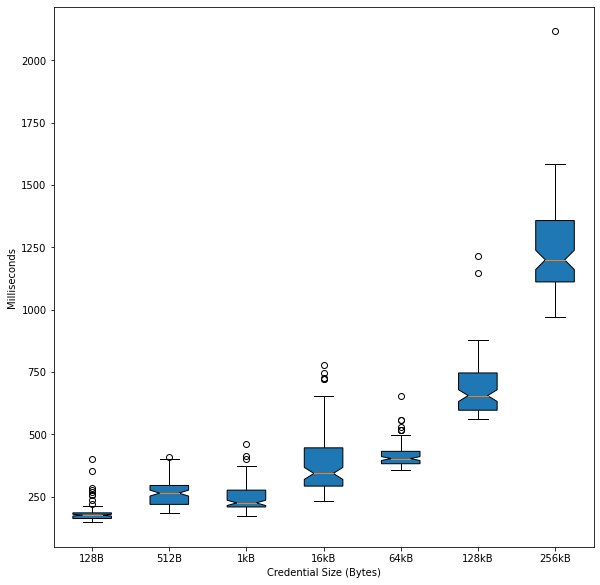

In [51]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 

 
fig = plt.figure(figsize =(10, 10))
 
# Creating axes instance
ax = fig.add_axes([0.1,0.1,0.75,0.75]) 
 
# Creating plot`
bp = ax.boxplot(data, patch_artist = True,
                notch ='True')

# x-axis labels
ax.set_xticklabels(labels)

plt.ylabel("Milliseconds")
plt.xlabel("Credential Size (Bytes)")

plt.savefig("results/verification/attribute_size/box_plot_non_revocable.png")

### Revocable

In [52]:
data = []
labels = []
revocable_averages = []
for result in revocable_experiment["results"]:
    
    millitimings = [i * 1000 for i in result["timings"]]
    data.append(millitimings)
    revocable_averages.append(result["average"] * 1000)
    labels.append(result["name"])
    


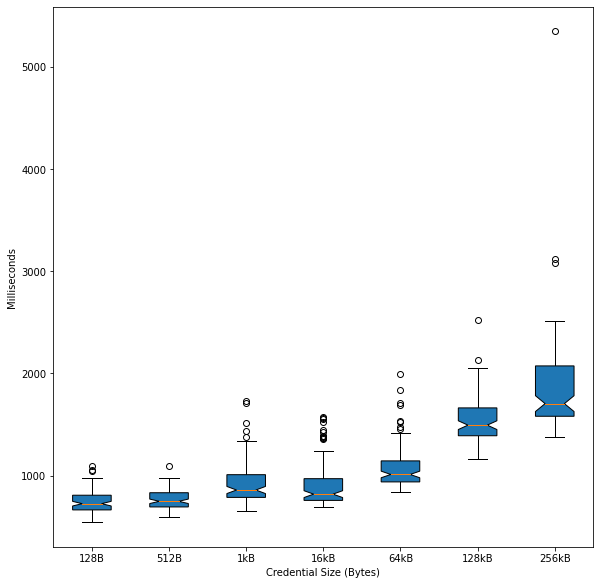

In [53]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 

 
fig = plt.figure(figsize =(10, 10))
 
# Creating axes instance
ax = fig.add_axes([0.1,0.1,0.75,0.75]) 
 
# Creating plot`
bp = ax.boxplot(data, patch_artist = True,
                notch ='True')

# x-axis labels
ax.set_xticklabels(labels)

plt.ylabel("Milliseconds")
plt.xlabel("Credential Size (Bytes)")

plt.savefig("results/verification/attribute_size/box_plot_revocable.png")

## Averages

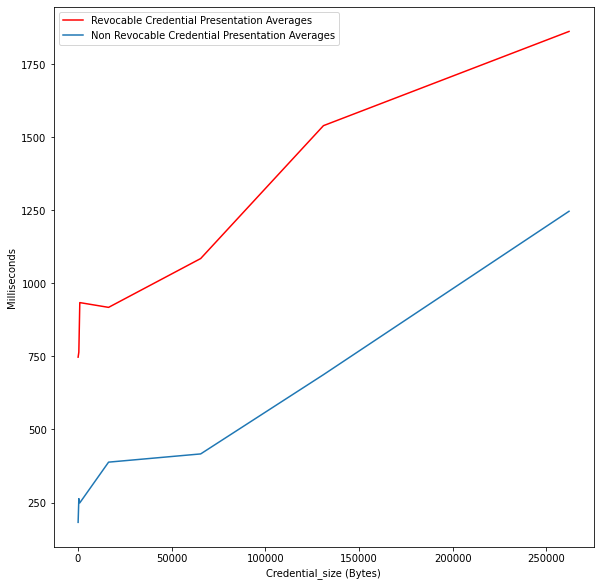

In [55]:
fig = plt.figure(figsize =(10, 10))
 
# Creating axes instance
ax = fig.add_axes([0.1,0.1,0.75,0.75]) 

# avg_ploy = plt.plot(labels, revocable_averages, non_revoked_averages)

plt_points = [128,512,1024,16*1024,64*1024,128*1024,256*1024]

plt.plot(plt_points, revocable_averages,'r-',label='Revocable Credential Presentation Averages')
plt.plot(plt_points, non_revocable_averages,label='Non Revocable Credential Presentation Averages')

plt.ylabel("Milliseconds")
plt.xlabel("Credential_size (Bytes)")


plt.legend()
plt.savefig("results/verification/attribute_size/averages.png")

## Save Experiments to File

In [57]:
performance_service.save_experiments()

## Terminate Controller

In [56]:
await agent_controller.terminate()

 RuntimeError('Site <aiohttp.web_runner.TCPSite object at 0x7f0cdee54c50> is not registered in runner <aiohttp.web_runner.AppRunner object at 0x7f0cef6d0830>') occurred.
